<a href="https://colab.research.google.com/github/z-devin/Remote-Sensing/blob/main/Flood_Map_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Remote Sensing Final Project

##Data Collection and Processing

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 78.4 MB/s eta 0:00:00


In [ ]:
import ee
import geemap
import pandas as pd
import numpy as np
import os
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import rasterio
import pickle

In [ ]:
!pip install earthengine-api
import ee
ee.Authenticate()
ee.Initialize(project='ee-devinzhangstudent')

In [ ]:
!pip install google-cloud-storage
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Creating the needed directories from Sen1Floods11 to Drive.

(RUN ONCE)

In [ ]:
!mkdir -p /content/drive/MyDrive/Sen1Floods11/v1.1/data/flood_events/HandLabeled/LabelHand
!mkdir -p /content/drive/MyDrive/Sen1Floods11/v1.1/data/flood_events/HandLabeled/S1Hand
!mkdir -p /content/drive/MyDrive/Sen1Floods11/v1.1/data/flood_events/HandLabeled/JRCWaterHand
!mkdir -p /content/drive/MyDrive/Sen1Floods11/v1.1/splits/flood_handlabeled
!mkdir -p /content/drive/MyDrive/Sen1Floods11/v1.1/splits/perm_water

Downloading Metadata file + Pre-determined Test, Train, Validation Split to Drive.

(RUN ONCE)

In [ ]:
!gsutil cp gs://sen1floods11/v1.1/Sen1Floods11_Metadata.geojson /content/drive/MyDrive/Sen1Floods11/v1.1/
print("Sen1Floods11_Metadata.geojson saved to Drive.")
!gsutil cp gs://sen1floods11/v1.1/splits/flood_handlabeled/flood_test_data.csv /content/drive/MyDrive/Sen1Floods11/v1.1/splits/flood_handlabeled/
!gsutil cp gs://sen1floods11/v1.1/splits/flood_handlabeled/flood_train_data.csv /content/drive/MyDrive/Sen1Floods11/v1.1/splits/flood_handlabeled/
!gsutil cp gs://sen1floods11/v1.1/splits/flood_handlabeled/flood_valid_data.csv /content/drive/MyDrive/Sen1Floods11/v1.1/splits/flood_handlabeled/
print("Flood Split saved to Drive.")
!gsutil cp gs://sen1floods11/v1.1/splits/perm_water/permanent_water_test_data.csv /content/drive/MyDrive/Sen1Floods11/v1.1/splits/perm_water/
!gsutil cp gs://sen1floods11/v1.1/splits/perm_water/permanent_water_train_data.csv /content/drive/MyDrive/Sen1Floods11/v1.1/splits/perm_water/
!gsutil cp gs://sen1floods11/v1.1/splits/perm_water/permanent_water_validation_data.csv /content/drive/MyDrive/Sen1Floods11/v1.1/splits/perm_water/
print("Permanent Water Split saved to Drive.")

Copying gs://sen1floods11/v1.1/Sen1Floods11_Metadata.geojson...
/ [1 files][ 13.8 KiB/ 13.8 KiB]                                                
Operation completed over 1 objects/13.8 KiB.                                     
Sen1Floods11_Metadata.geojson saved to Drive.
Copying gs://sen1floods11/v1.1/splits/flood_handlabeled/flood_test_data.csv...
/ [1 files][  4.7 KiB/  4.7 KiB]                                                
Operation completed over 1 objects/4.7 KiB.                                      
Copying gs://sen1floods11/v1.1/splits/flood_handlabeled/flood_train_data.csv...
/ [1 files][ 13.3 KiB/ 13.3 KiB]                                                
Operation completed over 1 objects/13.3 KiB.                                     
Copying gs://sen1floods11/v1.1/splits/flood_handlabeled/flood_valid_data.csv...
/ [1 files][  4.7 KiB/  4.7 KiB]                                                
Operation completed over 1 objects/4.7 KiB.                                      

Downloading Handlabeled Data, Sentinel-1 SAR Data, and JRC Water Data to Drive.

Approximately 739 MB of Disk Space.

(RUN ONCE)

In [ ]:
!gsutil -m cp gs://sen1floods11/v1.1/data/flood_events/HandLabeled/S1Hand/*.tif /content/drive/MyDrive/Sen1Floods11/v1.1/data/flood_events/HandLabeled/S1Hand
print("S1Hand saved to Drive")
!gsutil -m cp gs://sen1floods11/v1.1/data/flood_events/HandLabeled/LabelHand/*.tif /content/drive/MyDrive/Sen1Floods11/v1.1/data/flood_events/HandLabeled/LabelHand
print("LabelHand saved to Drive")
!gsutil -m cp gs://sen1floods11/v1.1/data/flood_events/HandLabeled/JRCWaterHand/*.tif /content/drive/MyDrive/Sen1Floods11/v1.1/data/flood_events/HandLabeled/JRCWaterHand
print("JRCWaterHand saved to Drive")

Copying gs://sen1floods11/v1.1/data/flood_events/HandLabeled/S1Hand/Bolivia_103757_S1Hand.tif...
Copying gs://sen1floods11/v1.1/data/flood_events/HandLabeled/S1Hand/Bolivia_129334_S1Hand.tif...
Copying gs://sen1floods11/v1.1/data/flood_events/HandLabeled/S1Hand/Bolivia_195474_S1Hand.tif...
Copying gs://sen1floods11/v1.1/data/flood_events/HandLabeled/S1Hand/Bolivia_23014_S1Hand.tif...
Copying gs://sen1floods11/v1.1/data/flood_events/HandLabeled/S1Hand/Bolivia_233925_S1Hand.tif...
Copying gs://sen1floods11/v1.1/data/flood_events/HandLabeled/S1Hand/Bolivia_242570_S1Hand.tif...
Copying gs://sen1floods11/v1.1/data/flood_events/HandLabeled/S1Hand/Bolivia_312675_S1Hand.tif...
Copying gs://sen1floods11/v1.1/data/flood_events/HandLabeled/S1Hand/Bolivia_294583_S1Hand.tif...
Copying gs://sen1floods11/v1.1/data/flood_events/HandLabeled/S1Hand/Bolivia_314919_S1Hand.tif...
Copying gs://sen1floods11/v1.1/data/flood_events/HandLabeled/S1Hand/Bolivia_290290_S1Hand.tif...
Copying gs://sen1floods11/v1.1/

Extracting geographic coordinates from GeoTIFF files in the Sen1Floods11 dataset by iterating through labeled Sentinel-1 images, parsing filenames for event and chip IDs, and using rasterio to obtain the bounding box coordinates of each image.

In [ ]:
base_path = '/content/drive/MyDrive/Sen1Floods11/v1.1/'

def extract_coordinates_from_tifs():
    event_chip_coords = []
    s1_directory = os.path.join(base_path, 'data/flood_events/HandLabeled/S1Hand')

    for filename in os.listdir(s1_directory):
        if filename.endswith('_S1Hand.tif'):
            # Extract event and chip ID
            parts = filename.split('_')
            event = parts[0]
            chip_id = parts[1]

            # Get coordinates from the file
            file_path = os.path.join(s1_directory, filename)
            with rasterio.open(file_path) as src:
                bounds = src.bounds

            # Store information
            event_chip_coords.append({
                'event': event,
                'chipId': chip_id,
                'xMin': bounds.left,
                'yMin': bounds.bottom,
                'xMax': bounds.right,
                'yMax': bounds.top
            })

    return event_chip_coords

Preparing and exporting terrain data (elevation and slope) for a specific flood event area by accessing NASA's NASADEM elevation data, calculating slope, and initiating an export task that matches the spatial properties (dimensions and projection) of the corresponding Sentinel-1 SAR image.

In [ ]:
def export_terrain_for_event(event, chip_id, bounds):
    # Create geometry from bounds
    region = ee.Geometry.Rectangle(bounds)

    # Get a reference to the S1 image to match its properties
    s1_path = os.path.join(base_path, 'data/flood_events/HandLabeled/S1Hand',
                          f'{event}_{chip_id}_S1Hand.tif')

    # Open the SAR image to get its projection and dimensions
    with rasterio.open(s1_path) as s1_src:
        s1_crs = s1_src.crs.to_string()  # Get CRS in EPSG or WKT format
        width = s1_src.width
        height = s1_src.height

    # Get elevation data
    dem = ee.Image("NASA/NASADEM_HGT/001").select('elevation').clip(region)
    dem_float = dem.toFloat()

    # Calculate slope
    slope = ee.Terrain.slope(dem_float)

    # Stack them
    terrain = dem_float.rename('elevation').addBands(slope.rename('slope'))

    # Export with both SAR dimensions and projection
    task = ee.batch.Export.image.toDrive(
        image=terrain,
        description=f"{event}_{chip_id}_Terrain",
        folder='Sen1Floods11_Terrain',
        fileNamePrefix=f"{event}_{chip_id}_Terrain",
        region=region,
        crs=s1_crs,                  # Match SAR projection
        dimensions=[width, height],  # Match SAR dimensions
        maxPixels=1e9
    )

    task.start()
    print(f'Started export for: {event}_{chip_id}')

In [ ]:
!mkdir -p /content/drive/MyDrive/Sen1Floods11_Terrain

Converting the extracted coordinates into a DataFrame and saving it as a CSV file, then looping through each event/chip pair to process terrain data exports by calling the export_terrain_for_event function with the appropriate parameters for each location.

In [ ]:
event_chip_coords = extract_coordinates_from_tifs()

# Save coordinates for reference
coords_df = pd.DataFrame(event_chip_coords)
coords_df.to_csv('/content/drive/MyDrive/Sen1Floods11/event_chip_coordinates.csv', index=False)

# Process each pair
print(f"Processing {len(event_chip_coords)} event/chip pairs...")
for i, pair in enumerate(event_chip_coords):
    print(f"Processing {i+1}/{len(event_chip_coords)}: {pair['event']}_{pair['chipId']}")
    export_terrain_for_event(
        pair['event'],
        pair['chipId'],
        [pair['xMin'], pair['yMin'], pair['xMax'], pair['yMax']]
    )

Processing 446 event/chip pairs...
Processing 1/446: Bolivia_103757
Started export for: Bolivia_103757
Processing 2/446: Bolivia_242570
Started export for: Bolivia_242570
Processing 3/446: Bolivia_312675
Started export for: Bolivia_312675
Processing 4/446: Ghana_24858
Started export for: Ghana_24858
Processing 5/446: Bolivia_294583
Started export for: Bolivia_294583
Processing 6/446: Ghana_26376
Started export for: Ghana_26376
Processing 7/446: Ghana_277
Started export for: Ghana_277
Processing 8/446: Ghana_264787
Started export for: Ghana_264787
Processing 9/446: Bolivia_290290
Started export for: Bolivia_290290
Processing 10/446: Ghana_308249
Started export for: Ghana_308249
Processing 11/446: Ghana_313799
Started export for: Ghana_313799
Processing 12/446: Ghana_359826
Started export for: Ghana_359826
Processing 13/446: Ghana_161233
Started export for: Ghana_161233
Processing 14/446: Ghana_319168
Started export for: Ghana_319168
Processing 15/446: Ghana_362274
Started export for: Gh

# Feature Extraction, Training, and Testing

Extracting features for flood classification by reading multiple geospatial datasets (SAR imagery, ground truth labels, JRC water occurrence, and terrain data), then randomly sampling pixels from water and non-water classes to build training data with features including VV and VH polarization values, slope, and JRC water occurrence.

In sen1floods11 documentation (https://openaccess.thecvf.com/content_CVPRW_2020/papers/w11/Bonafilia_Sen1Floods11_A_Georeferenced_Dataset_to_Train_and_Test_Deep_Learning_CVPRW_2020_paper.pdf), section 2.1 states they defined "permanent" water as pixels that had water at the beginning of 1984 and the end of 2018. "Not water" as pixels that either never had water or inconsistently had water.

I first start with a binary classification between non-water and water, then I set all permanent water pixels from JRC as permanent water.

In [ ]:
def extract_features(s1_path, label_path, jrc_path, terrain_path, samples_per_class=1000):
    X_data = []
    y_data = []

    try:
        # Read files using rasterio
        with rasterio.open(s1_path) as s1_src, \
             rasterio.open(label_path) as label_src, \
             rasterio.open(jrc_path) as jrc_src, \
             rasterio.open(terrain_path) as terrain_src:

            # Read all bands
            s1_data = s1_src.read()
            label_data = label_src.read(1)
            jrc_data = jrc_src.read(1)
            elevation_data = terrain_src.read(1)
            slope_data = terrain_src.read(2)

        non_water_mask = (label_data == 0)
        water_mask = (label_data == 1)

        for mask, class_label in [(non_water_mask, 0), (water_mask, 1)]:
            indices = np.where(mask)
            if len(indices[0]) > 0:
                # Random sampling
                sample_count = min(samples_per_class, len(indices[0]))
                sample_idx = np.random.choice(len(indices[0]), sample_count, replace=False)

                # Extract features
                for i in sample_idx:
                    r, c = indices[0][i], indices[1][i]
                    vv = s1_data[0, r, c]
                    vh = s1_data[1, r, c]
                    elevation = elevation_data[r, c]
                    slope = slope_data[r, c]
                    jrc_value = jrc_data[r, c]

                    X_data.append([vv, vh, elevation, slope, jrc_value])
                    y_data.append(class_label)

    except Exception as e:
        print(f"Error processing image {s1_path}: {e}")

    return np.array(X_data), np.array(y_data)

Loading and organizing datasets for flood classification then calling the extract_features function on each valid set of files.

In [ ]:
def load_dataset(split_file, base_path='/content/drive/MyDrive/'):
    df = pd.read_csv(split_file, header=None, names=['s1_path', 'label_path'])

    X_all = []
    y_all = []

    for _, row in df.iterrows():
        s1_filename = os.path.basename(row['s1_path'])
        parts = s1_filename.split('_')
        event = parts[0]
        chip_id = parts[1]

        # Construct file paths
        s1_path = os.path.join(base_path, 'Sen1Floods11/v1.1/data/flood_events/HandLabeled/S1Hand',
                                f'{event}_{chip_id}_S1Hand.tif')
        label_path = os.path.join(base_path, 'Sen1Floods11/v1.1/data/flood_events/HandLabeled/LabelHand',
                                  f'{event}_{chip_id}_LabelHand.tif')
        jrc_path = os.path.join(base_path, 'Sen1Floods11/v1.1/data/flood_events/HandLabeled/JRCWaterHand',
                                f'{event}_{chip_id}_JRCWaterHand.tif')
        terrain_path = os.path.join(base_path, 'Sen1Floods11_Terrain',
                                    f'{event}_{chip_id}_Terrain.tif')

        if not all(os.path.exists(p) for p in [s1_path, label_path, jrc_path, terrain_path]):
            print(f"Skipping {event}_{chip_id} - files missing")
            continue

        X, y = extract_features(s1_path, label_path, jrc_path, terrain_path)
        if len(X) > 0:
            X_all.append(X)
            y_all.append(y)

    return np.concatenate(X_all), np.concatenate(y_all)

Training a Random Forest classifier for flood mapping by:
- Creating a binary water/non-water classifier using SAR and terrain features (excluding JRC data)
- Post-processing the results with JRC permanent water data to create a three-class classification (non-water, flood water, permanent water)
- Generating evaluation metrics, confusion matrices, and feature importance visualizations.

In [ ]:
def train_and_evaluate(X_train, y_train, X_test, y_test):
    class_names = {
        0: 'Non-Water',
        1: 'Flood Water',
        2: 'Permanent Water'
    }

    jrc_train = X_train[:, -1]
    jrc_test = X_test[:, -1]

    # Remove JRC values from training features
    X_train_no_jrc = X_train[:, :-1]
    X_test_no_jrc = X_test[:, :-1]

    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train_no_jrc, y_train)

    y_pred_binary = rf_classifier.predict(X_test_no_jrc)

    # Now post-process to split water into flood and permanent using JRC values
    y_pred_3class = np.copy(y_pred_binary)

    y_pred_3class[(jrc_test == 1)] = 2

    y_test_3class = np.copy(y_test)
    y_test_3class[(jrc_test == 1)] = 2

    unique_classes = np.unique(np.concatenate([y_test_3class, y_pred_3class]))
    target_names = [class_names[c] for c in unique_classes]

    print("Binary training class distribution:", np.bincount(y_train))
    print("Binary testing class distribution:", np.bincount(y_test))
    print("Binary prediction distribution:", np.bincount(y_pred_binary))
    print("3-class ground truth distribution:", np.bincount(y_test_3class))
    print("3-class prediction distribution:", np.bincount(y_pred_3class))

    print("\nBinary Classification Report (water/non-water):")
    binary_target_names = ['Non-Water', 'Water']
    print(classification_report(y_test, y_pred_binary, target_names=binary_target_names))

    print("\nClassification Report (3 classes - Non-Water, Flood Water, Permanent Water):")
    print(classification_report(y_test_3class, y_pred_3class, target_names=target_names))

    cm = confusion_matrix(y_test_3class, y_pred_3class)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d',
               xticklabels=target_names,
               yticklabels=target_names)
    plt.title('Confusion Matrix (3 classes)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix_3class.png')

    feature_importance = rf_classifier.feature_importances_
    features = ['VV', 'VH', 'Elevation', 'Slope']
    importance_df = pd.DataFrame({
        'feature': features,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    plt.figure(figsize=(10,7))
    sns.barplot(x='importance', y='feature', data=importance_df)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.savefig('feature_importance.png')

    return rf_classifier

Main Execution and saving the trained model.

Binary training class distribution: [251000 196587]
Binary testing class distribution: [88000 77819]
Binary prediction distribution: [102017  63802]
3-class ground truth distribution: [86801 62192 16826]
3-class prediction distribution: [100515  48478  16826]

Binary Classification Report (water/non-water):
              precision    recall  f1-score   support

   Non-Water       0.75      0.87      0.81     88000
       Water       0.82      0.67      0.74     77819

    accuracy                           0.78    165819
   macro avg       0.78      0.77      0.77    165819
weighted avg       0.78      0.78      0.77    165819


Classification Report (3 classes - Non-Water, Flood Water, Permanent Water):
                 precision    recall  f1-score   support

      Non-Water       0.76      0.88      0.82     86801
    Flood Water       0.78      0.61      0.69     62192
Permanent Water       1.00      1.00      1.00     16826

       accuracy                           0.79    165819

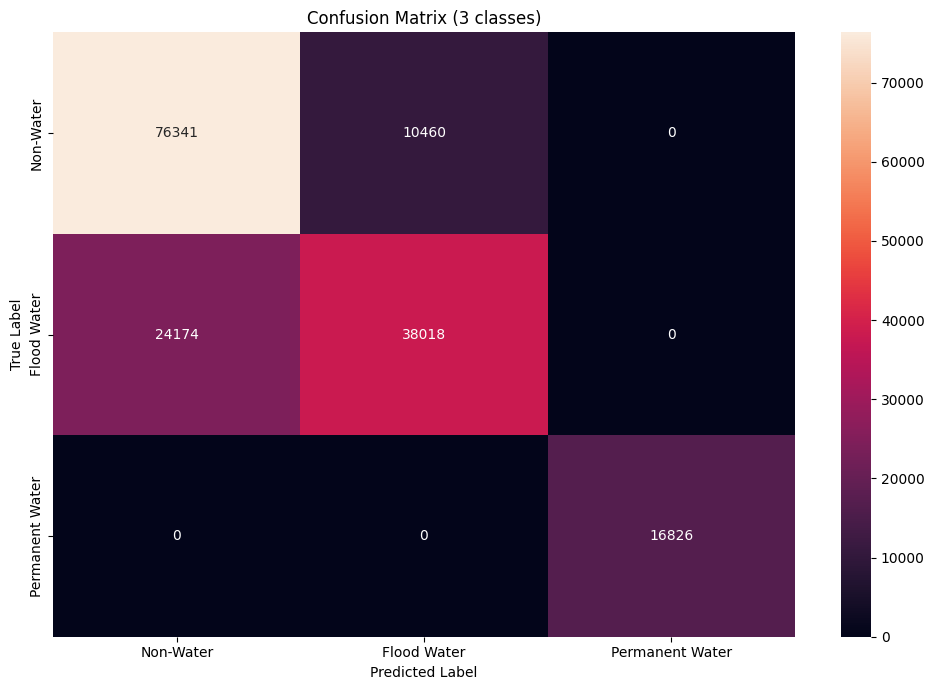

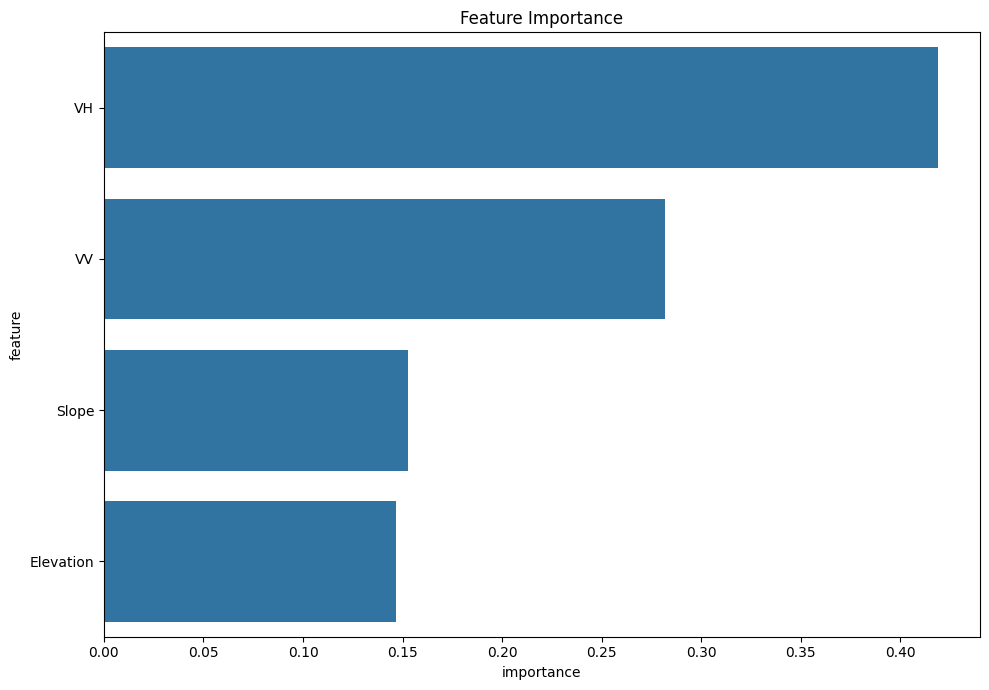

In [ ]:
base_path = '/content/drive/MyDrive/Sen1Floods11/v1.1/'
train_file = os.path.join(base_path, 'splits/flood_handlabeled/flood_train_data.csv')
test_file = os.path.join(base_path, 'splits/flood_handlabeled/flood_test_data.csv')

X_train, y_train = load_dataset(train_file)
X_test, y_test = load_dataset(test_file)

model = train_and_evaluate(X_train, y_train, X_test, y_test)

save_path = '/content/drive/MyDrive/Sen1Floods11/trained_rf_model.pkl'

with open(save_path, 'wb') as f:
    pickle.dump(model, f)

print(f"Model saved to {save_path}")

Interesting things I discovered while playing around with the features:
- It seems that Elevation only provides a small increase in performance. I will include it anyways.
- Using VV/VH ratio performs significantly worse than separating VV and VH and features. I will include VV and VH and exclude the ratio.

#Deployment on Untrained Area


Before we do anything, lets look at the region of interest before and after the flood.

I look for the number of available Sentinel-1 images for the flooding period and when they were taken.

I look for the number of Sentinel-2 images before and during the flood. This is just for visualization so I use .mosaic().

I also look at the elevation and slope data to make sure everything is working properly.


In [ ]:
import datetime

# Define region of interest (Matagorda County, Texas)
county = 'Matagorda'
statefp = '48'
roi = ee.FeatureCollection('TIGER/2018/Counties').filter(
   ee.Filter.And(
       ee.Filter.eq('NAME', county),
       ee.Filter.eq('STATEFP', statefp)
   )
)

flood_period = {'start': '2017-08-25', 'end': '2017-08-31'}
before_period = {'start': '2017-07-25', 'end': '2017-08-10'}

# Helper function for datetime formatting
def fmt(t_ms):
   """Convert epoch-ms to 'YYYY-MM-DD HH:MM:SS' (UTC)"""
   return datetime.datetime.utcfromtimestamp(t_ms / 1000).strftime('%Y-%m-%d %H:%M:%S')

s1_collection = (ee.ImageCollection("COPERNICUS/S1_GRD")
   .filterBounds(roi)
   .filterDate(flood_period['start'], flood_period['end'])
   .filter(ee.Filter.eq('instrumentMode', 'IW'))
   .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
   .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
   .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING')))

n_s1_images = s1_collection.size().getInfo()
print(f"Number of Sentinel-1 images available: {n_s1_images}")

if n_s1_images > 0:
   ids = s1_collection.aggregate_array('system:index').getInfo()
   times = s1_collection.aggregate_array('system:time_start').getInfo()
   print("Acquisition date & time (UTC):")
   for img_id, t in zip(ids, times):
       print(f" • {fmt(t)}Z {img_id}")

s2_flood = (ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
   .filterBounds(roi)
   .filterDate(flood_period['start'], flood_period['end'])
   .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 60)))

s2_before = (ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
   .filterBounds(roi)
   .filterDate(before_period['start'], before_period['end'])
   .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)))

print(f'Number of Sentinel-2 images (flood period): {s2_flood.size().getInfo()}')
print(f'Number of Sentinel-2 images (before period): {s2_before.size().getInfo()}')

s2_flood_mosaic = s2_flood.mosaic().clip(roi)
s2_before_mosaic = s2_before.mosaic().clip(roi)

# Load DEM and compute slope
dem = ee.Image("NASA/NASADEM_HGT/001").select('elevation').clip(roi).toFloat()
slope = ee.Terrain.slope(dem).toFloat()

elevation_stats = dem.reduceRegion(
   reducer=ee.Reducer.minMax(),
   geometry=roi,
   scale=30,
   maxPixels=1e9
)
min_elevation = elevation_stats.get('elevation_min').getInfo()
max_elevation = elevation_stats.get('elevation_max').getInfo()
print(f'Elevation min/max: {min_elevation}/{max_elevation}')

rgb_vis = {'min': 0, 'max': 4000, 'bands': ['B4', 'B3', 'B2']}
dem_vis = {'min': min_elevation, 'max': max_elevation, 'palette': ['blue', 'green', 'yellow', 'red']}
slope_vis = {'min': 0, 'max': 30, 'palette': ['green', 'yellow', 'red']}

NAIP = ee.ImageCollection("USDA/NAIP/DOQQ") \
 .filterBounds(roi) \
 .filterDate('2016-01-01', '2017-08-31') \
 .mosaic() \
 .clip(roi)

Map = geemap.Map()
Map.addLayer(roi, {}, 'ROI')
Map.addLayer(NAIP, {'bands': ['R', 'G', 'B']}, 'NAIP Before')
Map.addLayer(s2_before_mosaic, rgb_vis, 'Before Flood (S2)')
Map.addLayer(s2_flood_mosaic, rgb_vis, 'During Flood (S2)')
Map.centerObject(roi, 10)
Map

Number of Sentinel-1 images available: 2
Acquisition date & time (UTC):
 • 2017-08-30 12:22:03Z S1B_IW_GRDH_1SDV_20170830T122203_20170830T122232_007169_00CA2C_E7BF
 • 2017-08-30 12:22:32Z S1B_IW_GRDH_1SDV_20170830T122232_20170830T122257_007169_00CA2C_CC8C
Number of Sentinel-2 images (flood period): 6
Number of Sentinel-2 images (before period): 5
Elevation min/max: -15/35


Map(center=[28.7854855704117, -96.00423718595611], controls=(WidgetControl(options=['position', 'transparent_b…

Now, to process the data:
- I filter the SAR imagery, selecting only ones with VV and VH during descending passes. This is important because SAR backscatter can vary significantly with different viewing angles.

- I then use a minimum value composite across the time period for both VV and VH bands. This is because water appears as dark with low backscatter in VV polarization.

- I extract the SAR data projection and resolution and reproject the elevation and slope data to match.

- I extract the JRC permanent water data.

Then, I combine all these layers (VV, VH, elevation, slope, and permanent water) into a single multi-band image.

Then, I export this feature stack.



In [ ]:
s1 = ee.ImageCollection("COPERNICUS/S1_GRD") \
    .filterBounds(roi) \
    .filterDate('2017-08-25', '2017-08-31') \
    .filter(ee.Filter.eq('instrumentMode', 'IW')) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
    .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING')) \

s1 = s1_collection.select(['VV', 'VH']).min().clip(roi)

s1_projection = s1.projection()
s1_scale = s1_projection.nominalScale()

vv = s1.select('VV').toFloat()
vh = s1.select('VH').toFloat()

# Get DEM
dem = ee.Image("NASA/NASADEM_HGT/001") \
 .select('elevation') \
 .clip(roi) \
 .toFloat()

# Calculate slope
slope = ee.Terrain.slope(dem) \
 .toFloat()

# Get JRC data
jrc = ee.Image("JRC/GSW1_4/GlobalSurfaceWater").clip(roi)
transition = jrc.select('transition')
permanentWater = transition.eq(1).rename('JRC_Water').toFloat()

feature_stack = ee.Image.cat([
    vv.rename('VV'),
    vh.rename('VH'),
    dem.rename('Elevation'),
    slope.rename('Slope'),
    permanentWater.rename('JRC_Water'),
])

# Export
task = ee.batch.Export.image.toDrive(
    image=feature_stack,
    description=f'{county}_feature_Stack',
    folder=f'Sen1Floods11_{county}',
    fileNamePrefix=f'{county}_feature_stack',
    region=roi.geometry(),
    scale=10,
    maxPixels=1e10
)
task.start()

Add each feature as a layer to the map.

In [ ]:
# Get Sentinel-1 data
s1_collection = ee.ImageCollection("COPERNICUS/S1_GRD") \
 .filterBounds(roi) \
 .filterDate('2016-01-01', '2017-08-31') \
 .filter(ee.Filter.eq('instrumentMode', 'IW')) \
 .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
 .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
 .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))

s1 = s1_collection.select(['VV', 'VH']).min().clip(roi)
s1_projection = s1.projection()
s1_scale = s1_projection.nominalScale()
vv = s1.select('VV').toFloat()
vh = s1.select('VH').toFloat()

# Get DEM data
dem = ee.Image("NASA/NASADEM_HGT/001") \
 .select('elevation') \
 .clip(roi) \
 .toFloat()  # Added toFloat()

# Calculate slope
slope = ee.Terrain.slope(dem) \
 .toFloat()

# Get JRC data
jrc = ee.Image("JRC/GSW1_4/GlobalSurfaceWater").clip(roi)
transition = jrc.select('transition')
permanentWater = transition.eq(1).rename('JRC_Water').toFloat()

# Calculate statistics for better visualization
vv_stats = vv.reduceRegion(
    reducer=ee.Reducer.percentile([5, 95]),
    geometry=roi,
    scale=10,
    maxPixels=1e9
).getInfo()

vh_stats = vh.reduceRegion(
    reducer=ee.Reducer.percentile([5, 95]),
    geometry=roi,
    scale=10,
    maxPixels=1e9
).getInfo()

dem_stats = dem.reduceRegion(
    reducer=ee.Reducer.percentile([1, 99]),
    geometry=roi,
    scale=30,
    maxPixels=1e9
).getInfo()

slope_stats = slope.reduceRegion(
    reducer=ee.Reducer.percentile([1, 99]),
    geometry=roi,
    scale=30,
    maxPixels=1e9
).getInfo()

# Extract the min-max values
vv_min = vv_stats['VV_p5'] if 'VV_p5' in vv_stats else -25
vv_max = vv_stats['VV_p95'] if 'VV_p95' in vv_stats else 0

vh_min = vh_stats['VH_p5'] if 'VH_p5' in vh_stats else -30
vh_max = vh_stats['VH_p95'] if 'VH_p95' in vh_stats else -5

dem_min = dem_stats['elevation_p1'] if 'elevation_p1' in dem_stats else 0
dem_max = dem_stats['elevation_p99'] if 'elevation_p99' in dem_stats else 3000

slope_min = slope_stats['slope_p1'] if 'slope_p1' in slope_stats else 0
slope_max = slope_stats['slope_p99'] if 'slope_p99' in slope_stats else 45

# Print statistics to console for reference
print("VV range:", vv_min, "to", vv_max)
print("VH range:", vh_min, "to", vh_max)
print("Slope range:", slope_min, "to", slope_max)

# Add layers to the map with calculated min-max values
Map.addLayer(
 vv,
 {'min': vv_min, 'max': vv_max},
 'Sentinel-1 VV'
)

Map.addLayer(
 vh,
 {'min': vh_min, 'max': vh_max},
 'Sentinel-1 VH',
 False
)

Map.addLayer(
 dem,
 {'min': dem_min, 'max': dem_max, 'palette': ['blue', 'green', 'yellow', 'orange', 'red']},
 'DEM',
 False
)

Map.addLayer(
 slope,
 {'min': slope_min, 'max': slope_max, 'palette': ['black', 'red']},
 'Slope',
 False
)

Map.addLayer(
 permanentWater,
 {'min': 0, 'max': 1, 'palette': ['black', 'blue']},
 'JRC Permanent Water',
 False
)

Map

VV range: -21.87004725324806 to -9.378038986694731
VH range: -31.872794417096063 to -15.128177216472267
VV/VH Ratio range: 0.5479515458675241 to 0.7945350266792313
DEM range: -1 to 24.000000000000004
Slope range: 0 to 3.517003929463049


Map(bottom=109469.0, center=[28.7854855704117, -96.00423718595611], controls=(WidgetControl(options=['position…

With the feature stack and the trained model, I can now deploy the model onto the untrained region. Then, I set the JRC pixels to permanent water and pixels with no VV, VH, and slope as a null pixel.

In [ ]:
from rasterio.plot import reshape_as_image, reshape_as_raster
import matplotlib.colors as mcolors

base_path = f'/content/drive/MyDrive/Sen1Floods11_{county}'
tiff_file = os.path.join(base_path, f'{county}_feature_stack.tif')

load_path = '/content/drive/MyDrive/Sen1Floods11/trained_rf_model.pkl'

with open(load_path, 'rb') as f:
    model = pickle.load(f)

with rasterio.open(tiff_file) as src:
    bands = src.read()
    profile = src.profile
    height, width = bands.shape[1], bands.shape[2]

X = np.stack([bands[0], bands[1], bands[2], bands[3]], axis=-1).reshape(-1, 4)

y_pred = model.predict(X)

prediction_map = y_pred.reshape((height, width)).astype(np.uint8)

prediction_map[bands[4]== 1] = 2  # Set JRC
prediction_map[np.isnan(bands[0:3]).any(axis=0)] = 3  # Set Null

out_path = f'/content/drive/MyDrive/Sen1Floods11_{county}/{county}_flood_prediction.tif'

Visualizing the prediction map.

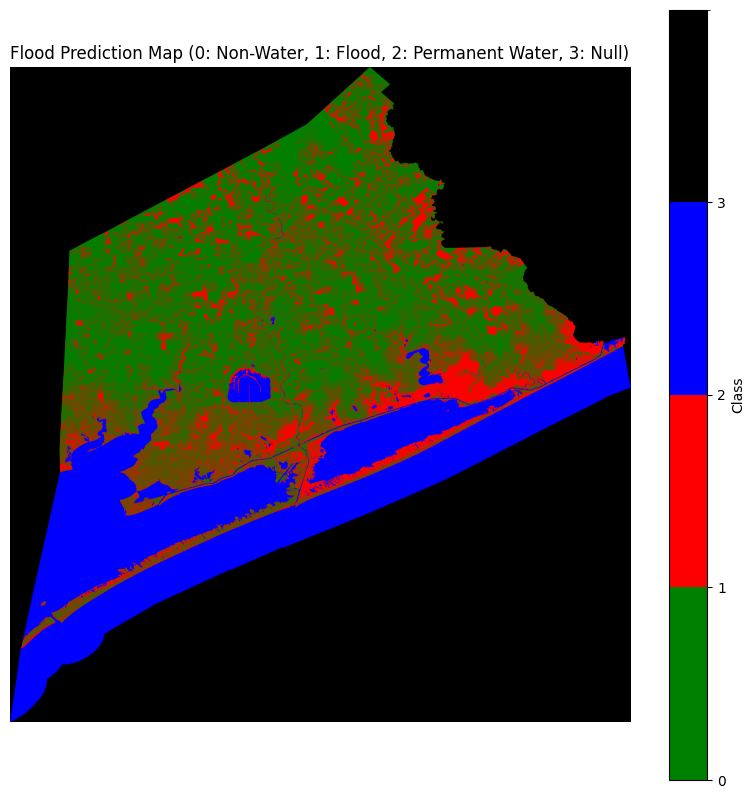

In [ ]:
cmap = mcolors.ListedColormap(['green', 'red', 'blue', 'black'])
bounds = [0, 1, 2, 3, 4]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(10, 10))
plt.imshow(prediction_map, cmap=cmap, norm=norm)
plt.colorbar(ticks=[0, 1, 2, 3], label='Class')
plt.title('Flood Prediction Map (0: Non-Water, 1: Flood, 2: Permanent Water, 3: Null)')
plt.axis('off')
plt.show()

Saving the prediction map.

In [ ]:
with rasterio.open(out_path, 'w', **{
    **profile,
    'count': 1,
    'dtype': 'uint8'
}) as dst:
    dst.write(prediction_map, 1)

Here, I overlay this prediction map over the GEE map so I can zoom in and see if the model is doing well.

In [ ]:
!pip install localtileserver

In [ ]:
cmap = ['green', 'red', 'blue', 'black']

Map.add_raster(out_path,
               layer_name='Flood Prediction',
               bands=[1],
               opacity=0.7,
               colormap=cmap,
               nodata=3)

Map

Map(bottom=109469.0, center=[28.7854855704117, -96.00423718595611], controls=(WidgetControl(options=['position…

The model seems to be doing well!

Here, I convert the EE ROI to be used with rasterio and geopandas. Then I take the reference file and clip it to the EE ROI.

I preserve the metadata of the original file but update the dimensions and transformation to match the region.

Then visualize the image.

Generating URL ...
Please wait ...
Data downloaded to /content/roi.shp


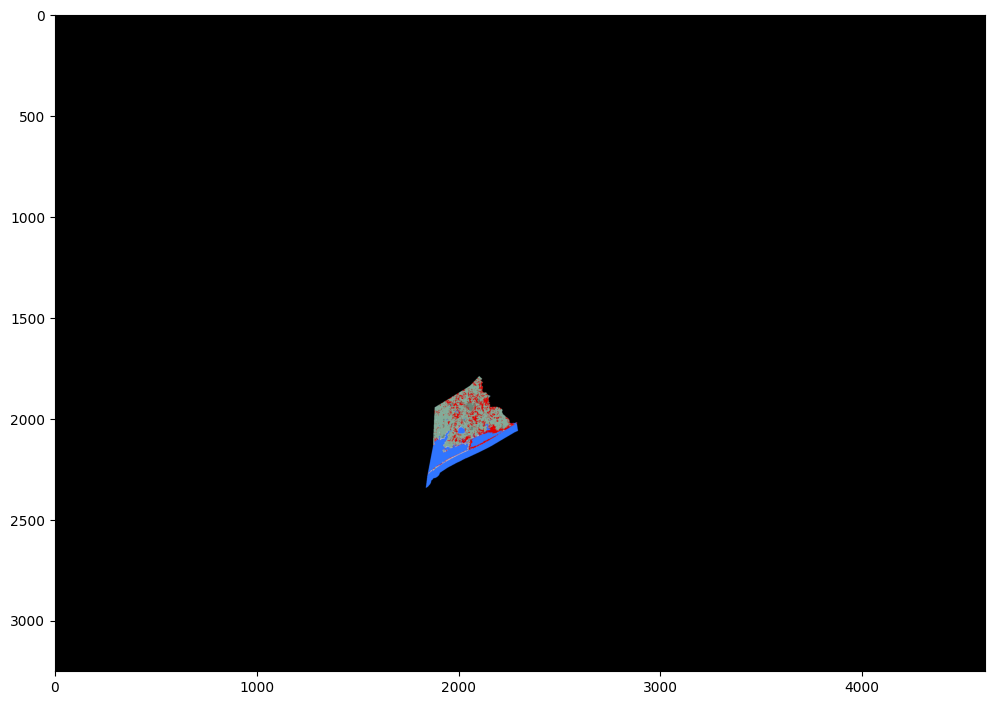

In [ ]:
# Path to TIF file
tif_path = f'/content/drive/MyDrive/Sen1Floods11_{county}/2017USA4510.tif'


import geopandas as gpd
from rasterio.mask import mask

temp_shp = '/content/roi.shp'
geemap.ee_export_vector(roi, temp_shp)
roi_gdf = gpd.read_file(temp_shp)

# Open the TIF file
with rasterio.open(tif_path) as src:
    # Clip raster with the ROI polygon
    clipped_data, clipped_transform = mask(src, roi_gdf.geometry, crop=False)

    # Copy the metadata
    clipped_meta = src.meta.copy()

    # Update metadata
    clipped_meta.update({
        "height": clipped_data.shape[1],
        "width": clipped_data.shape[2],
        "transform": clipped_transform
    })

# Save the clipped raster
clipped_tif_path = f'/content/drive/MyDrive/Sen1Floods11_{county}/{county}_reference_flood_map.tif'
with rasterio.open(clipped_tif_path, 'w', **clipped_meta) as dst:
    dst.write(clipped_data)

# Visualize the clipped raster
plt.figure(figsize=(12, 12))

# If RGB bands
rgb_image = np.transpose(clipped_data, (1, 2, 0))
plt.imshow(rgb_image)

Now, we need to convert the RGB image into classes using their RGB values. I pulled the .tif into QGIS and found the exact RGB values they used. Then I "classified" them using this.

In [ ]:
def classify_reference_map(clipped_data, clipped_meta, clipped_transform, output_folder, county_name):
    # Define RGB values for flood and permanent water (adjust as needed)

    perm_water_rgb = [48, 117, 255]  # Blue for permanent water
    flood_rgb = [224, 0, 0]  # Red for flood

    # Create classification map
    class_map = np.zeros((clipped_data.shape[1], clipped_data.shape[2]), dtype=np.uint8)

    # Check each pixel against the RGB values
    for i in range(clipped_data.shape[1]):
        for j in range(clipped_data.shape[2]):
            r, g, b = clipped_data[0, i, j], clipped_data[1, i, j], clipped_data[2, i, j]
            if r == flood_rgb[0] and g == flood_rgb[1] and b == flood_rgb[2]:
                class_map[i, j] = 1  # Flood
            elif r == perm_water_rgb[0] and g == perm_water_rgb[1] and b == perm_water_rgb[2]:
                class_map[i, j] = 2  # Permanent water
            elif r == 0 and g == 0 and b == 0:
                class_map[i, j] = 3  # Null
            else:
                class_map[i, j] = 0  # Non-water

    # Calculate statistics
    flood_pixels = np.sum(class_map == 1)
    perm_water_pixels = np.sum(class_map == 2)
    non_water_pixels = np.sum(class_map == 0)
    total_pixels = non_water_pixels + flood_pixels + perm_water_pixels

    print(f"Reference Classification Statistics:")
    print(f"Flood area: {flood_pixels} pixels ({flood_pixels/total_pixels*100:.2f}%)")
    print(f"Permanent water area: {perm_water_pixels} pixels ({perm_water_pixels/total_pixels*100:.2f}%)")
    print(f"Non-water area: {non_water_pixels} pixels ({non_water_pixels/total_pixels*100:.2f}%)")

    # Visualize the classification map
    plt.figure(figsize=(12, 12))
    cmap = mcolors.ListedColormap(['green', 'red', 'blue', 'black'])  # 0=green, 1=red, 2=blue, 3=black
    plt.imshow(class_map, cmap=cmap)
    plt.colorbar(ticks=[0.5, 1.5, 2.5, 3.5]).set_ticklabels(['Non-Water', 'Flood', 'Permanent Water', 'Null'])
    plt.title('Reference Classification Map')
    plt.axis('off')
    plt.show()

    # Save the classification map
    class_map_path = os.path.join(output_folder, f'{county_name}_reference_classified.tif')

    with rasterio.open(class_map_path, 'w', **{
        **clipped_meta,
        'count': 1,
        'dtype': 'uint8'
    }) as dst:
        dst.write(class_map, 1)

    print(f"Classified reference map saved to: {class_map_path}")
    return class_map_path

Reference Classification Statistics:
Flood area: 19991 pixels (17.44%)
Permanent water area: 37218 pixels (32.47%)
Non-water area: 57416 pixels (50.09%)


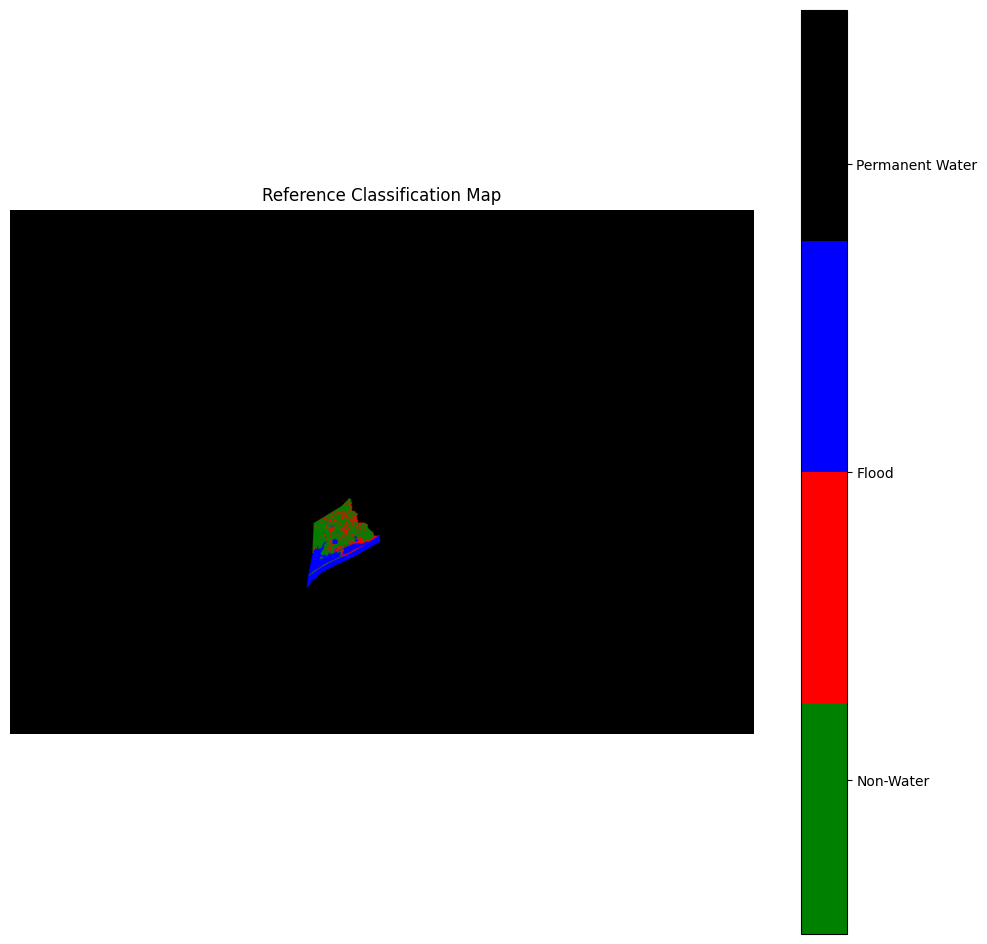

Classified reference map saved to: /content/drive/MyDrive/Sen1Floods11_Matagorda/Matagorda_reference_classified.tif


In [ ]:
output_folder = f'/content/drive/MyDrive/Sen1Floods11_{county}'
clipped_tif_path = f'{output_folder}/{county}_reference_flood_map.tif'

with rasterio.open(clipped_tif_path) as src:
    clipped_data = src.read()
    clipped_meta = src.meta
    clipped_transform = src.transform

classified_map_path = classify_reference_map(
    clipped_data,
    clipped_meta,
    clipped_transform,
    output_folder,
    county
)

It looks good!

Now to compare the two:
- I load both .tif files, and print the shape, bounds, and coordinate reference systems for both.
- I reproject and resample the reference map to match our prediction map.
- I visualize both for a side-by-side comparison.
- I generate a confusion matrix and calculate accuracy metrics.


Prediction raster shape: (10576, 10015)
Prediction bounds: BoundingBox(left=-96.39524869842826, bottom=28.279683796309833, right=-95.49558594138256, top=29.229742040794637)
Prediction CRS: EPSG:4326
Reference raster shape: (3250, 4608)
Reference bounds: BoundingBox(left=-100.0087063650442, bottom=26.728040813075577, right=-90.94523335448066, top=32.29037927568214)
Reference CRS: EPSG:4269


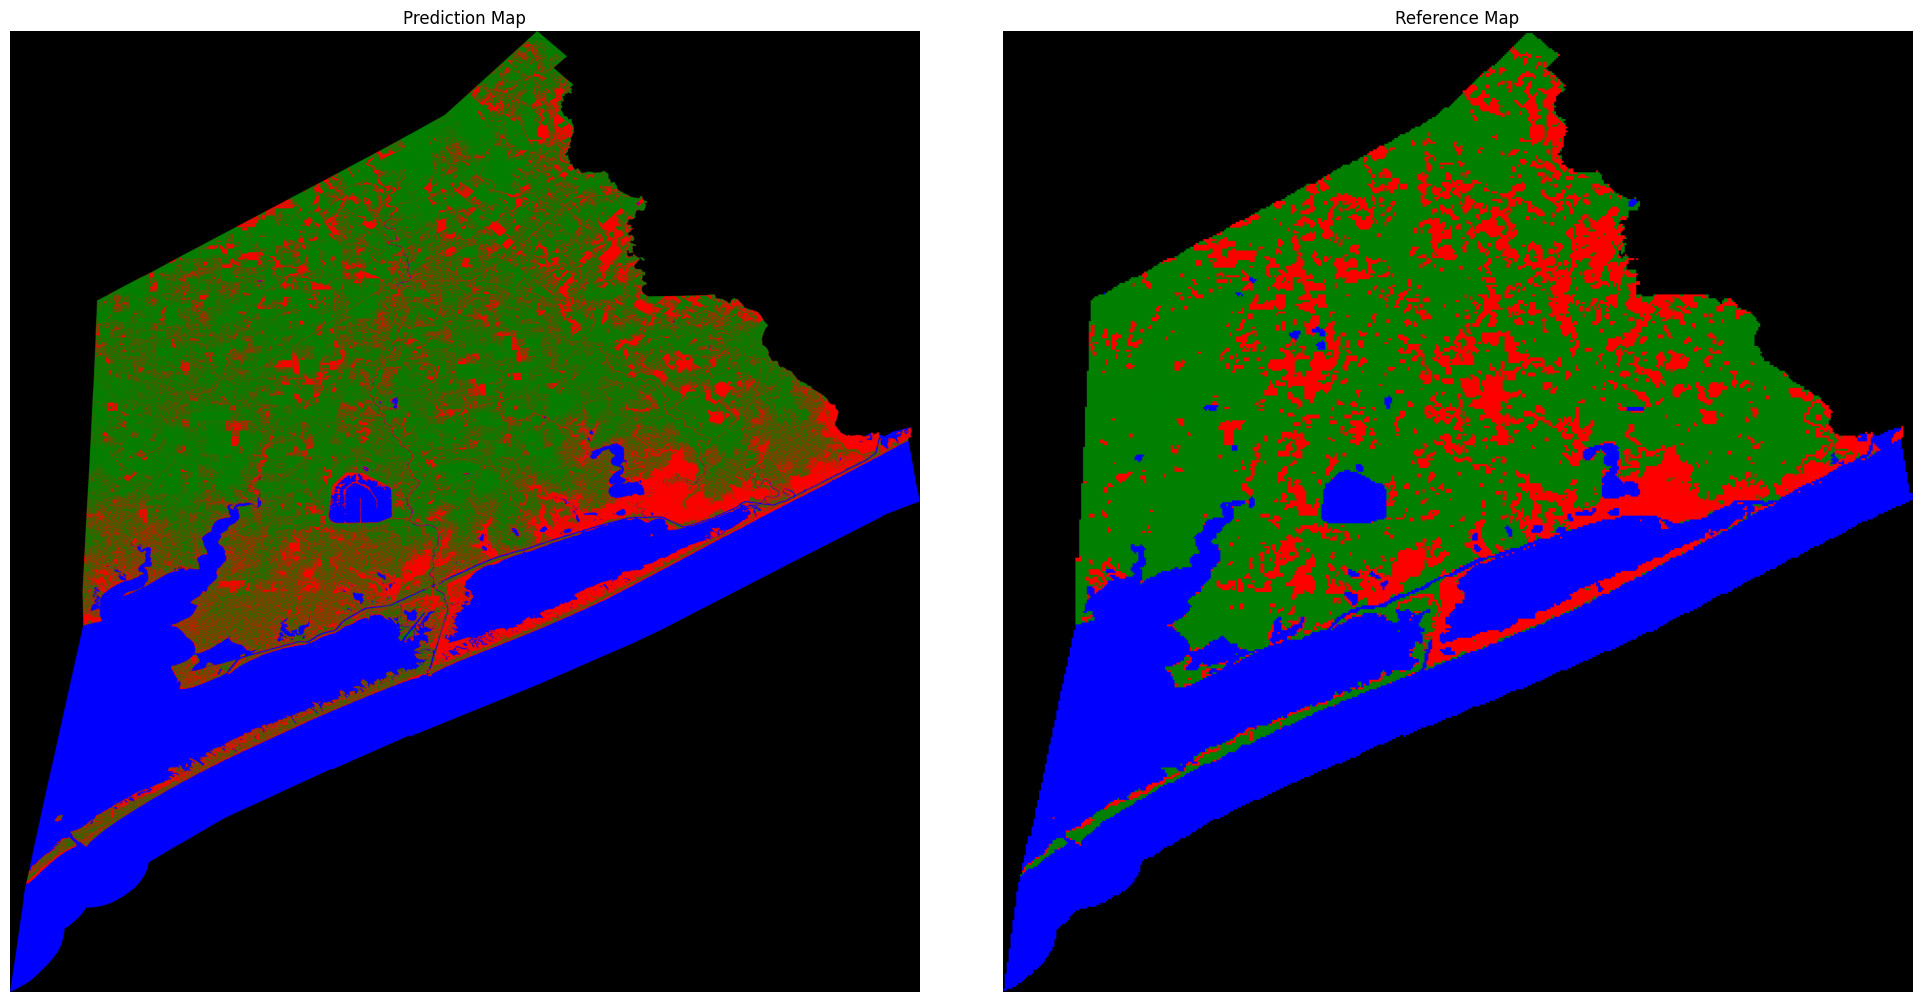


Value counts in aligned reference map:
Class 0: 23967619 pixels (22.63%)
Class 1: 8333766 pixels (7.87%)
Class 2: 15509530 pixels (14.64%)
Class 3: 58107725 pixels (54.86%)

Confusion Matrix (excluding Null Pixels):
[[18807704  5080993    47492]
 [ 3881303  4360542    69409]
 [  390501   724442 14342101]]

Classification Report (excluding Null Pixels):
                 precision    recall  f1-score   support

      Non-Water       0.81      0.79      0.80  23936189
     Temp Flood       0.43      0.52      0.47   8311254
Permanent Water       0.99      0.93      0.96  15457044

       accuracy                           0.79  47704487
      macro avg       0.75      0.75      0.74  47704487
   weighted avg       0.81      0.79      0.79  47704487



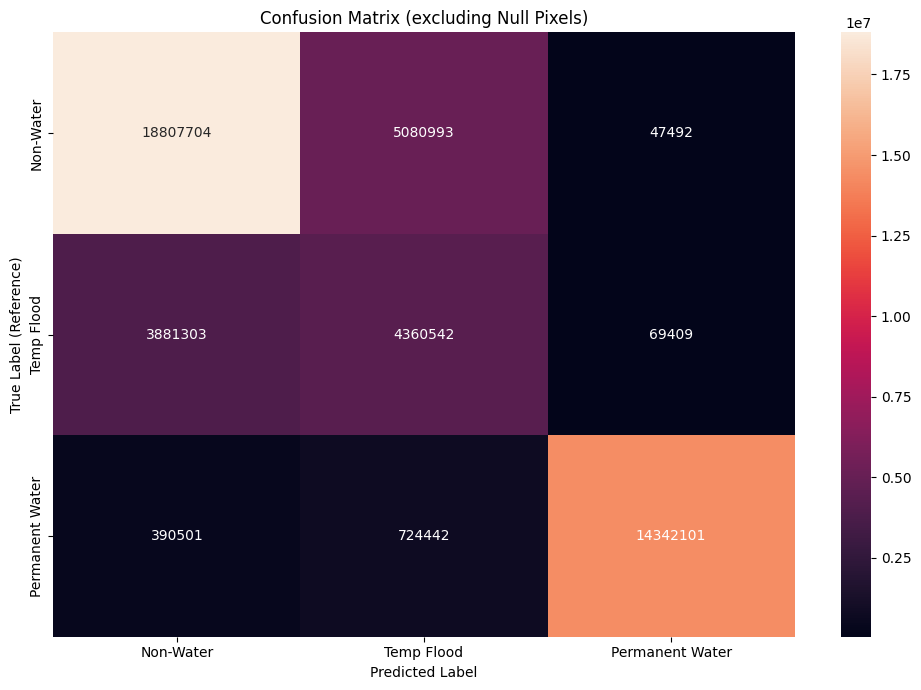

Overall Accuracy (excluding null pixels): 0.7863

Null pixels in reference: 58107725 (54.86%)
Null pixels in prediction: 58072530 (54.83%)


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.colors as mcolors

# Load both files
prediction_path = f'/content/drive/MyDrive/Sen1Floods11_{county}/{county}_flood_prediction.tif'
reference_path = f'/content/drive/MyDrive/Sen1Floods11_{county}/{county}_reference_classified.tif'

with rasterio.open(prediction_path) as pred_src:
    prediction_orig = pred_src.read(1)
    pred_meta = pred_src.meta.copy()
    pred_bounds = pred_src.bounds
    pred_transform = pred_src.transform
    pred_crs = pred_src.crs

with rasterio.open(reference_path) as ref_src:
    reference_orig = ref_src.read(1)
    ref_meta = ref_src.meta.copy()
    ref_bounds = ref_src.bounds
    ref_transform = ref_src.transform
    ref_crs = ref_src.crs

# Print information about both datasets
print(f"Prediction raster shape: {prediction_orig.shape}")
print(f"Prediction bounds: {pred_bounds}")
print(f"Prediction CRS: {pred_crs}")
print(f"Reference raster shape: {reference_orig.shape}")
print(f"Reference bounds: {ref_bounds}")
print(f"Reference CRS: {ref_crs}")

Reproject reference to match prediction
dst_crs = pred_crs
transform, width, height = calculate_default_transform(
    ref_crs, dst_crs, reference_orig.shape[0], reference_orig.shape[1],
    left=ref_bounds.left, bottom=ref_bounds.bottom,
    right=ref_bounds.right, top=ref_bounds.top
)

reference_reproj = np.zeros((height, width), dtype=reference_orig.dtype)
reproject(
    source=reference_orig,
    destination=reference_reproj,
    src_transform=ref_transform,
    src_crs=ref_crs,
    dst_transform=transform,
    dst_crs=dst_crs,
    resampling=Resampling.nearest
)

# Now resample to match prediction size
reference = np.zeros_like(prediction_orig)
reproject(
    source=reference_reproj,
    destination=reference,
    src_transform=transform,
    src_crs=dst_crs,
    dst_transform=pred_transform,
    dst_crs=dst_crs,
    resampling=Resampling.nearest
)

# Display the maps side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Updated color map for 4 classes
cmap = mcolors.ListedColormap(['green', 'red', 'blue', 'black'])  # 0=green, 1=red, 2=blue, 3=black
bounds = [0, 1, 2, 3, 4]  # Updated bounds for 4 classes
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Prediction map
ax1.imshow(prediction_orig, cmap=cmap, norm=norm)
ax1.set_title('Prediction Map')
ax1.axis('off')

# Aligned reference map
ax2.imshow(reference, cmap=cmap, norm=norm)
ax2.set_title('Reference Map')
ax2.axis('off')

plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/Sen1Floods11/maps_comparison.png')
plt.show()

# Now create proper confusion matrix
pred_flat = prediction_orig.flatten()
ref_flat = reference.flatten()

# Check value distributions after reprojection
print("\nValue counts in aligned reference map:")
for val in np.unique(reference):
    count = np.sum(reference == val)
    print(f"Class {val}: {count} pixels ({count/reference.size*100:.2f}%)")

# Filter out null pixels (class 3) for confusion matrix and classification report
valid_mask = (ref_flat < 3) & (pred_flat < 3)
ref_valid = ref_flat[valid_mask]
pred_valid = pred_flat[valid_mask]

# Create class names for the first three classes only
class_names = ['Non-Water', 'Temp Flood', 'Permanent Water']

# Create confusion matrix without null pixels, using only the first three classes
cm = confusion_matrix(ref_valid, pred_valid, labels=[0, 1, 2])
print("\nConfusion Matrix (excluding Null Pixels):")
print(cm)

# Classification report without null pixels, using only the first three classes
print("\nClassification Report (excluding Null Pixels):")
print(classification_report(ref_valid, pred_valid, labels=[0, 1, 2], target_names=class_names))

# Visualize confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d',
           xticklabels=class_names,
           yticklabels=class_names)
plt.title('Confusion Matrix (excluding Null Pixels)')
plt.ylabel('True Label (Reference)')
plt.xlabel('Predicted Label')
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/Sen1Floods11/confusion_matrix.png')
plt.show()

# Calculate accuracy (excluding null pixels)
accuracy = np.sum(pred_valid == ref_valid) / len(ref_valid)
print(f"Overall Accuracy (excluding null pixels): {accuracy:.4f}")

# Additionally, report on null pixels
null_ref = np.sum(ref_flat == 3)
null_pred = np.sum(pred_flat == 3)
print(f"\nNull pixels in reference: {null_ref} ({null_ref/len(ref_flat)*100:.2f}%)")
print(f"Null pixels in prediction: {null_pred} ({null_pred/len(pred_flat)*100:.2f}%)")

The maps seem to get most of the non-water and permanent water correct (which doesn't mean too much because I am pulling them from JRC). However, what is concerning is that it performs worse when it comes to predicting the temporary flood pixels.

However, it is important to note that the reference dataset, from https://floodobservatory.colorado.edu/Events/2017USA4510/2017USA4510.html, classified the event differently.

They took two Sentinel-1 SAR images, one before the flood and one after. Applied a 7x7 pixel low-pass filter to both images to reduce noise. Then applied a threshold (ranging form 50-70) to identify dark pixels (water). Then, calculated a ratio of flood image/pre-flood image, and applied a threshold (from 0.5-0.7) to this ratio to identify pixels that became much darker during the flood than before. Then used an "AND" operation to find pixels that satisfy both.

Their classified image was also at a lower resolution than the one produced by our model.

Therefore, I believe that a qualitative approach to validating our model is more valuable.

Here, we add the reference to the Map as a layer.

In [ ]:
Map.add_raster('/content/drive/MyDrive/Sen1Floods11_Matagorda/Matagorda_reference_classified.tif',
               layer_name='Reference',
               bands=[1],
               colormap=cmap,
               nodata=3)

Map

Map(bottom=109495.0, center=[29.509210000000003, -95.4769695], controls=(WidgetControl(options=['position', 't…

# Modularization

To make the code more deployable, I made the code more modular for easier application.

However, the reference map is specific to Matagorda, so if you want to apply it to another region, changes to the reference map functions are most likely necessary.

In [ ]:
import ee
import geemap
import os
import datetime
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import rasterio
import geopandas as gpd
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from sklearn.metrics import confusion_matrix, classification_report
from rasterio.plot import reshape_as_image, reshape_as_raster

def get_county_roi(county_name, state_fips):
    roi = ee.FeatureCollection('TIGER/2018/Counties').filter(
        ee.Filter.And(
            ee.Filter.eq('NAME', county_name),
            ee.Filter.eq('STATEFP', state_fips)
        )
    )
    return roi

def fmt_time(t_ms):
    return datetime.datetime.utcfromtimestamp(t_ms / 1000).strftime('%Y-%m-%d %H:%M:%S')

def analyze_sentinel_data(roi, start_date, end_date):
    # Sentinel-1 collection
    s1_collection = (ee.ImageCollection("COPERNICUS/S1_GRD")
        .filterBounds(roi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.eq('instrumentMode', 'IW'))
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
        .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING')))

    # Count and info for S1 images
    n_s1 = s1_collection.size().getInfo()
    print(f"Number of Sentinel-1 images available: {n_s1}")

    if n_s1 > 0:
        ids = s1_collection.aggregate_array('system:index').getInfo()
        times = s1_collection.aggregate_array('system:time_start').getInfo()
        print("Acquisition date & time (UTC):")
        for img_id, t in zip(ids, times):
            print(f" • {fmt_time(t)}Z {img_id}")

    # Get Sentinel-2 imagery
    s2_flood = ee.ImageCollection("COPERNICUS/S2_HARMONIZED") \
        .filterBounds(roi) \
        .filterDate(start_date, end_date) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 60))

    # Get pre-flood imagery for comparison
    pre_flood_start = (datetime.datetime.strptime(start_date, '%Y-%m-%d') -
                      datetime.timedelta(days=30)).strftime('%Y-%m-%d')
    pre_flood_end = (datetime.datetime.strptime(start_date, '%Y-%m-%d') -
                     datetime.timedelta(days=1)).strftime('%Y-%m-%d')

    s2_before = ee.ImageCollection("COPERNICUS/S2_HARMONIZED") \
        .filterBounds(roi) \
        .filterDate(pre_flood_start, pre_flood_end) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))

    print(f'Number of Sentinel-2 flood period images found: {s2_flood.size().getInfo()}')
    print(f'Number of Sentinel-2 pre-flood images found: {s2_before.size().getInfo()}')

    return s1_collection, s2_flood, s2_before

def create_terrain_features(roi):
    dem = ee.Image("NASA/NASADEM_HGT/001") \
        .select('elevation') \
        .clip(roi) \
        .toFloat()

    slope = ee.Terrain.slope(dem) \
        .toFloat()

    # Get elevation statistics
    elevation_stats = dem.reduceRegion(
        reducer=ee.Reducer.minMax(),
        geometry=roi,
        scale=30,
        maxPixels=1e9
    ).getInfo()

    min_elevation = elevation_stats['elevation_min']
    max_elevation = elevation_stats['elevation_max']

    print(f'Elevation range: {min_elevation} to {max_elevation} meters')

    return dem, slope, min_elevation, max_elevation

def display_map(roi, dem, slope, min_elevation, max_elevation, s2_flood, s2_before):
    # Prepare visualizations
    s2_flood_median = s2_flood.median().clip(roi)
    s2_before_median = s2_before.median().clip(roi)

    vis_params = {
        'min': 0,
        'max': 4000,
        'bands': ['B4', 'B3', 'B2']
    }

    # Create map
    Map = geemap.Map()
    Map.addLayer(roi, {}, 'ROI')
    Map.addLayer(dem, {'min': min_elevation, 'max': max_elevation,
                       'palette': ['blue', 'green', 'yellow', 'red']}, 'DEM')
    Map.addLayer(slope, {'min': 0, 'max': 30,
                        'palette': ['green', 'yellow', 'red']}, 'Slope')

    if s2_flood.size().getInfo() > 0:
        Map.addLayer(s2_flood_median, vis_params, 'Flood Period')

    if s2_before.size().getInfo() > 0:
        Map.addLayer(s2_before_median, vis_params, 'Pre-Flood')

    Map.centerObject(roi, 10)
    return Map

def create_feature_stack(roi, s1_collection, output_folder, county_name):
    # Median S1 image
    s1 = s1_collection.select(['VV', 'VH']).min().clip(roi)
    s1_projection = s1.projection()
    s1_scale = s1_projection.nominalScale()

    # Create S1 features
    vv = s1.select('VV').toFloat()
    vh = s1.select('VH').toFloat()

    # Get and reproject DEM
    dem = ee.Image("NASA/NASADEM_HGT/001") \
        .select('elevation') \
        .clip(roi) \
        .toFloat()

    # Calculate slope
    slope = ee.Terrain.slope(dem) \
        .toFloat()

    # Get JRC water data
    jrc = ee.Image("JRC/GSW1_4/GlobalSurfaceWater").clip(roi)
    transition = jrc.select('transition')
    permanentWater = transition.eq(1).rename('JRC_Water').toFloat()

    # Create the feature stack
    feature_stack = ee.Image.cat([
        vv.rename('VV'),
        vh.rename('VH'),
        dem.rename('Elevation'),
        slope.rename('Slope'),
        permanentWater.rename('JRC_Water'),
    ])

    # Export the feature stack
    task = ee.batch.Export.image.toDrive(
        image=feature_stack,
        description=f'{county_name}_Feature_Stack',
        folder=output_folder,
        fileNamePrefix=f'{county_name}_feature_stack',
        region=roi.geometry(),
        scale=10,
        maxPixels=1e10
    )

    task.start()
    print(f"Feature stack export started.")

    return feature_stack

def predict_flood_map(feature_stack_path, model_path, output_folder, county_name):
    # Load the model
    with open(model_path, 'rb') as f:
        model = pickle.load(f)

    # Load the feature stack
    with rasterio.open(feature_stack_path) as src:
        bands = src.read()
        profile = src.profile
        height, width = bands.shape[1], bands.shape[2]

    # Prepare data for prediction
    X = np.stack([bands[0], bands[1], bands[2], bands[3]],
                  axis=-1).reshape(-1, 4)

    # Make prediction
    y_pred = model.predict(X)
    prediction_map = y_pred.reshape((height, width)).astype(np.uint8)

    # Set NaN or invalid pixels to class 3 (null)
    prediction_map[bands[4]== 1] = 2
    prediction_map[np.isnan(bands[0:3]).any(axis=0)] = 3

    # Save the prediction map
    out_path = os.path.join(output_folder, f'{county_name}_flood_prediction.tif')

    with rasterio.open(out_path, 'w', **{
        **profile,
        'count': 1,
        'dtype': 'uint8',
        'nodata': 3
    }) as dst:
        dst.write(prediction_map, 1)

    print(f"Flood prediction map saved to: {out_path}")
    return prediction_map, out_path

def visualize_prediction(prediction_map):
    cmap = mcolors.ListedColormap(['green', 'red', 'blue', 'black'])
    bounds = [0, 1, 2, 3, 4]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(12, 12))
    plt.imshow(prediction_map, cmap=cmap, norm=norm)
    plt.colorbar(ticks=[0, 1, 2, 3], label='Class')
    plt.title('Flood Prediction Map (0: Non-Water, 1: Flood, 2: Permanent Water, 3: Null)')
    plt.axis('off')
    plt.show()

    # Calculate statistics
    non_water = np.sum(prediction_map == 0)
    flood = np.sum(prediction_map == 1)
    perm_water = np.sum(prediction_map == 2)
    null = np.sum(prediction_map == 3)

    total_valid = non_water + flood + perm_water
    total = prediction_map.size

    # Area calculations (assuming 10m pixels)
    pixel_area_sqm = 10 * 10  # 10m x 10m pixels
    non_water_area = non_water * pixel_area_sqm
    flood_area = flood * pixel_area_sqm
    perm_water_area = perm_water * pixel_area_sqm

    print(f"Non-Water Area: {non_water_area/1e6:.2f} km²")
    print(f"Flood Area: {flood_area/1e6:.2f} km²")
    print(f"Permanent Water Area: {perm_water_area/1e6:.2f} km²")
    print(f"Total Valid Area: {(non_water_area + flood_area + perm_water_area)/1e6:.2f} km²")
    print(f"Flood Percentage: {flood_area/(non_water_area + flood_area + perm_water_area)*100:.2f}%")

    return {
        'non_water_area_km2': non_water_area/1e6,
        'flood_area_km2': flood_area/1e6,
        'perm_water_area_km2': perm_water_area/1e6,
        'flood_percentage': flood_area/(non_water_area + flood_area + perm_water_area)*100
    }

def prepare_reference_map(roi, reference_tif_path, output_folder, county_name):
    # Convert EE feature to shapefile
    temp_shp = os.path.join(output_folder, 'temp_roi.shp')
    geemap.ee_export_vector(roi, temp_shp)
    roi_gdf = gpd.read_file(temp_shp)

    # Open and clip the reference TIF
    with rasterio.open(reference_tif_path) as src:
        # Clip raster with the ROI polygon
        clipped_data, clipped_transform = mask(src, roi_gdf.geometry, crop=False)

        # Copy and update metadata
        clipped_meta = src.meta.copy()
        clipped_meta.update({
            "height": clipped_data.shape[1],
            "width": clipped_data.shape[2],
            "transform": clipped_transform
        })

    # Save the clipped reference map
    reference_out_path = os.path.join(output_folder, f'{county_name}_reference_flood_map.tif')

    with rasterio.open(reference_out_path, 'w', **clipped_meta) as dst:
        dst.write(clipped_data)

    print(f"Reference map saved to: {reference_out_path}")

    # Classify reference map (assuming RGB reference map)
    if clipped_data.shape[0] == 3:  # RGB image
        ref_class_path = classify_reference_map(clipped_data, clipped_meta, clipped_transform,
                                            output_folder, county_name)
        return reference_out_path, ref_class_path
    else:
        return reference_out_path, None

def classify_reference_map(clipped_data, clipped_meta, clipped_transform, output_folder, county_name):
    # Define RGB values for flood and permanent water (adjust as needed)
    perm_water_rgb = [48, 117, 255]  # Blue for permanent water
    flood_rgb = [224, 0, 0]  # Red for flood

    # Create classification map
    class_map = np.zeros((clipped_data.shape[1], clipped_data.shape[2]), dtype=np.uint8)

    # Check each pixel against the RGB values
    for i in range(clipped_data.shape[1]):
        for j in range(clipped_data.shape[2]):
            r, g, b = clipped_data[0, i, j], clipped_data[1, i, j], clipped_data[2, i, j]
            if r == flood_rgb[0] and g == flood_rgb[1] and b == flood_rgb[2]:
                class_map[i, j] = 1  # Flood
            elif r == perm_water_rgb[0] and g == perm_water_rgb[1] and b == perm_water_rgb[2]:
                class_map[i, j] = 2  # Permanent water
            elif r == 0 and g == 0 and b == 0:
                class_map[i, j] = 3  # Null
            else:
                class_map[i, j] = 0  # Non-water

    # Calculate statistics
    flood_pixels = np.sum(class_map == 1)
    perm_water_pixels = np.sum(class_map == 2)
    non_water_pixels = np.sum(class_map == 0)
    total_pixels = non_water_pixels + flood_pixels + perm_water_pixels

    print(f"Reference Classification Statistics:")
    print(f"Flood area: {flood_pixels} pixels ({flood_pixels/total_pixels*100:.2f}%)")
    print(f"Permanent water area: {perm_water_pixels} pixels ({perm_water_pixels/total_pixels*100:.2f}%)")
    print(f"Non-water area: {non_water_pixels} pixels ({non_water_pixels/total_pixels*100:.2f}%)")

    # Visualize the classification map
    plt.figure(figsize=(12, 12))
    cmap = mcolors.ListedColormap(['green', 'red', 'blue', 'black'])  # 0=green, 1=red, 2=blue, 3=black
    plt.imshow(class_map, cmap=cmap)
    plt.colorbar(ticks=[1, 2, 3, 4]).set_ticklabels(['Non-Water', 'Flood', 'Permanent Water', 'Null'])
    plt.title('Reference Classification Map')
    plt.axis('off')
    plt.show()

    # Save the classification map
    class_map_path = os.path.join(output_folder, f'{county_name}_reference_classified.tif')

    with rasterio.open(class_map_path, 'w', **{
        **clipped_meta,
        'count': 1,
        'dtype': 'uint8'
    }) as dst:
        dst.write(class_map, 1)

    print(f"Classified reference map saved to: {class_map_path}")
    return class_map_path

def accuracy_assessment(prediction_path, reference_path):
    # Load both files
    with rasterio.open(prediction_path) as pred_src:
        prediction_orig = pred_src.read(1)
        pred_meta = pred_src.meta.copy()
        pred_bounds = pred_src.bounds
        pred_transform = pred_src.transform
        pred_crs = pred_src.crs

    with rasterio.open(reference_path) as ref_src:
        reference_orig = ref_src.read(1)
        ref_meta = ref_src.meta.copy()
        ref_bounds = ref_src.bounds
        ref_transform = ref_src.transform
        ref_crs = ref_src.crs

    # Print information about both datasets
    print(f"Prediction raster shape: {prediction_orig.shape}")
    print(f"Reference raster shape: {reference_orig.shape}")

    # Reproject reference to match prediction
    dst_crs = pred_crs
    transform, width, height = calculate_default_transform(
        ref_crs, dst_crs, reference_orig.shape[0], reference_orig.shape[1],
        left=ref_bounds.left, bottom=ref_bounds.bottom,
        right=ref_bounds.right, top=ref_bounds.top
    )

    reference_reproj = np.zeros((height, width), dtype=reference_orig.dtype)
    reproject(
        source=reference_orig,
        destination=reference_reproj,
        src_transform=ref_transform,
        src_crs=ref_crs,
        dst_transform=transform,
        dst_crs=dst_crs,
        resampling=Resampling.nearest
    )

    # Now resample to match prediction size
    reference = np.zeros_like(prediction_orig)
    reproject(
        source=reference_reproj,
        destination=reference,
        src_transform=transform,
        src_crs=dst_crs,
        dst_transform=pred_transform,
        dst_crs=dst_crs,
        resampling=Resampling.nearest
    )

    # Display the maps side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Updated color map for 4 classes
    cmap = mcolors.ListedColormap(['green', 'red', 'blue', 'black'])  # 0=green, 1=red, 2=blue, 3=black
    bounds = [0, 1, 2, 3, 4]  # Updated bounds for 4 classes
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Prediction map
    ax1.imshow(prediction_orig, cmap=cmap, norm=norm)
    ax1.set_title('Prediction Map')
    ax1.axis('off')

    # Aligned reference map
    ax2.imshow(reference, cmap=cmap, norm=norm)
    ax2.set_title('Reference Map')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

    # Now create proper confusion matrix
    pred_flat = prediction_orig.flatten()
    ref_flat = reference.flatten()

    # Check value distributions after reprojection
    print("\nValue counts in aligned reference map:")
    for val in np.unique(reference):
        count = np.sum(reference == val)
        print(f"Class {val}: {count} pixels ({count/reference.size*100:.2f}%)")

    # Filter out null pixels for confusion matrix and classification report
    valid_mask = (ref_flat < 3) & (pred_flat < 3)
    ref_valid = ref_flat[valid_mask]
    pred_valid = pred_flat[valid_mask]

    # Create class names for the first three classes only
    class_names = ['Non-Water', 'Temp Flood', 'Permanent Water']

    # Create confusion matrix without null pixels, using only the first three classes
    cm = confusion_matrix(ref_valid, pred_valid, labels=[0, 1, 2])
    print("\nConfusion Matrix (excluding Null Pixels):")
    print(cm)

    # Classification report without null pixels, using only the first three classes
    print("\nClassification Report (excluding Null Pixels):")
    print(classification_report(ref_valid, pred_valid, labels=[0, 1, 2], target_names=class_names))

    # Visualize confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d',
               xticklabels=class_names,
               yticklabels=class_names)
    plt.title('Confusion Matrix (excluding Null Pixels)')
    plt.ylabel('True Label (Reference)')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Calculate accuracy (excluding null pixels)
    accuracy = np.sum(pred_valid == ref_valid) / len(ref_valid)
    print(f"Overall Accuracy (excluding null pixels): {accuracy:.4f}")

    # Return accuracy metrics
    return {
        'confusion_matrix': cm,
        'overall_accuracy': accuracy,
        'classification_report': classification_report(ref_valid, pred_valid,
                                                     labels=[0, 1, 2],
                                                     target_names=class_names,
                                                     output_dict=True)
    }

def prepare_feature_stack(county_name, state_fips, start_date, end_date, output_folder='Sen1Floods11_Matagorda'):
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Get ROI
    roi = get_county_roi(county_name, state_fips)

    # Analyze Sentinel data
    s1_collection, s2_flood, s2_before = analyze_sentinel_data(roi, start_date, end_date)

    # Generate terrain features
    dem, slope, min_elevation, max_elevation = create_terrain_features(roi)

    # Display map
    Map = display_map(roi, dem, slope, min_elevation, max_elevation, s2_flood, s2_before)

    # Create and export feature stack
    feature_stack = create_feature_stack(roi, s1_collection, output_folder, county_name)

    print(f"Feature stack export initiated. Task will complete in Earth Engine.")
    print(f"After export completes, download and place the file at: {output_folder}/{county_name}_feature_stack.tif")

    return Map, roi

def run_flood_prediction(county_name, model_path, feature_stack_path, reference_tif_path=None, output_folder='Sen1Floods11_Matagorda'):
    # Check if feature stack exists locally
    if not os.path.exists(feature_stack_path):
        print(f"Feature stack not found at {feature_stack_path}")
        print("Please wait for the Earth Engine export to complete, then move the file to the output folder.")
        return None, None

    print('Generating Predictions')
    # Generate prediction
    prediction_map, prediction_path = predict_flood_map(
        feature_stack_path, model_path, output_folder, county_name)

    print('Visualizing Predictions')
    # Visualize prediction
    stats = visualize_prediction(prediction_map)

    # Process reference data if provided
    if reference_tif_path and os.path.exists(reference_tif_path):
        # Create ROI if needed for reference map preparation
        roi = get_county_roi(county_name, '48')  # Assuming Texas FIPS code

        reference_path, reference_classified_path = prepare_reference_map(
            roi, reference_tif_path, output_folder, county_name)

        # Perform accuracy assessment if classified reference is available
        if reference_classified_path and os.path.exists(reference_classified_path):
            accuracy_metrics = accuracy_assessment(prediction_path, reference_classified_path)

    # Return statistics
    return prediction_map, stats

In [ ]:
# Step 1: Run the feature preparation and export
Map, roi = prepare_feature_stack('Matagorda', '48', '2017-08-25', '2017-08-31')

Number of Sentinel-1 images available: 2
Acquisition date & time (UTC):
 • 2017-08-30 12:22:03Z S1B_IW_GRDH_1SDV_20170830T122203_20170830T122232_007169_00CA2C_E7BF
 • 2017-08-30 12:22:32Z S1B_IW_GRDH_1SDV_20170830T122232_20170830T122257_007169_00CA2C_CC8C
Number of Sentinel-2 flood period images found: 6
Number of Sentinel-2 pre-flood images found: 14
Elevation range: -15 to 35 meters
Feature stack export started. Check your Earth Engine tasks.
Feature stack export initiated. Task will complete in Earth Engine.
After export completes, download and place the file at: Sen1Floods11_Matagorda/Matagorda_feature_stack.tif


Generating Predictions
Flood prediction map saved to: /content/drive/MyDrive/Sen1Floods11_Matagorda/Matagorda_flood_prediction.tif
Visualizing Predictions


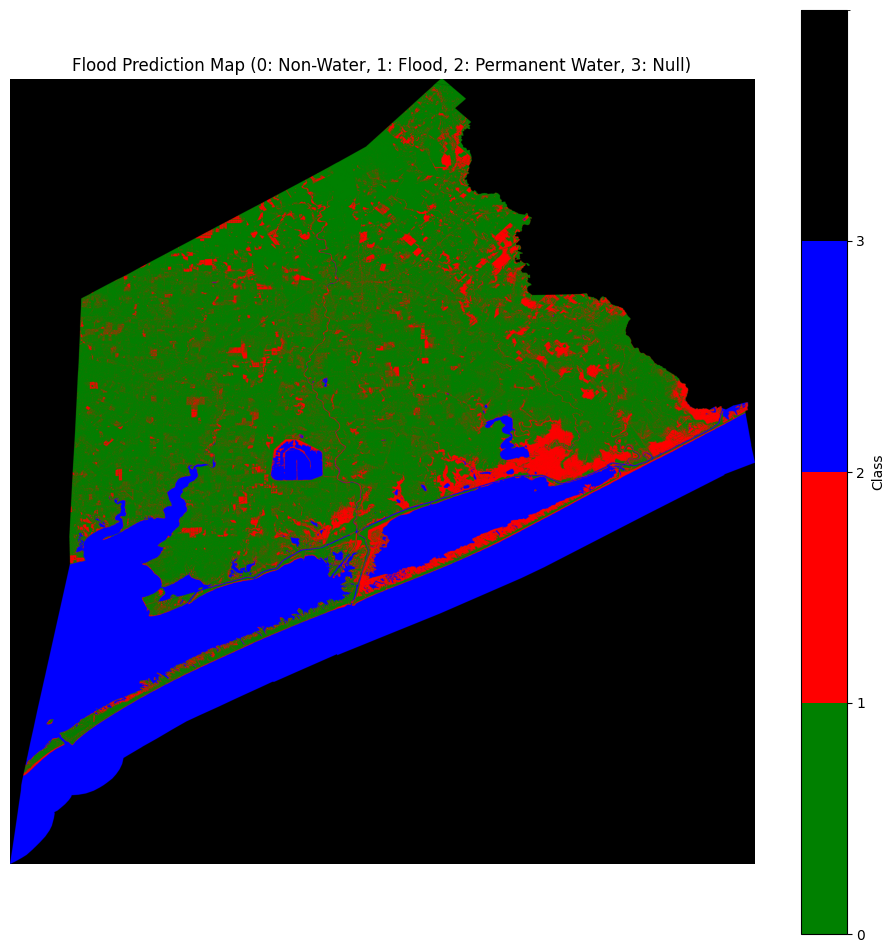

Non-Water Area: 2692.80 km²
Flood Area: 639.79 km²
Permanent Water Area: 1452.03 km²
Total Valid Area: 4784.61 km²
Flood Percentage: 13.37%


In [ ]:
# Step 2: Run the prediction when the feature stack file is available locally
prediction_map, stats = run_flood_prediction(
    'Matagorda',
    '/content/drive/MyDrive/Sen1Floods11/trained_rf_model.pkl',
    '/content/drive/MyDrive/Sen1Floods11_Matagorda/Matagorda_feature_stack.tif',
    '/content/drive/MyDrive/Sen1Floods11_Matagorda/2017USA4510.tif',
    '/content/drive/MyDrive/Sen1Floods11_Matagorda'
)

Generating GEE Map

In [ ]:
import datetime
out_path = '/content/drive/MyDrive/Sen1Floods11_Matagorda/Matagorda_flood_prediction.tif'

county = 'Matagorda'
statefp = '48'
roi = ee.FeatureCollection('TIGER/2018/Counties').filter(
   ee.Filter.And(
       ee.Filter.eq('NAME', county),
       ee.Filter.eq('STATEFP', statefp)
   )
)

flood_period = {'start': '2017-08-25', 'end': '2017-08-31'}
before_period = {'start': '2017-07-25', 'end': '2017-08-10'}

# Helper function for datetime formatting
def fmt(t_ms):
   """Convert epoch-ms to 'YYYY-MM-DD HH:MM:SS' (UTC)"""
   return datetime.datetime.utcfromtimestamp(t_ms / 1000).strftime('%Y-%m-%d %H:%M:%S')

# Load Sentinel-1 SAR data
s1_collection = (ee.ImageCollection("COPERNICUS/S1_GRD")
   .filterBounds(roi)
   .filterDate(flood_period['start'], flood_period['end'])
   .filter(ee.Filter.eq('instrumentMode', 'IW'))
   .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
   .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
   .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING')))

# Print S1 image information
n_s1_images = s1_collection.size().getInfo()
print(f"Number of Sentinel-1 images available: {n_s1_images}")

if n_s1_images > 0:
   ids = s1_collection.aggregate_array('system:index').getInfo()
   times = s1_collection.aggregate_array('system:time_start').getInfo()
   print("Acquisition date & time (UTC):")
   for img_id, t in zip(ids, times):
       print(f" • {fmt(t)}Z {img_id}")

s1 = s1_collection.select(['VV', 'VH']).min().clip(roi)
s1_projection = s1.projection()
s1_scale = s1_projection.nominalScale()
vv = s1.select('VV').toFloat()
vh = s1.select('VH').toFloat()

vv_min = vv_stats['VV_p5'] if 'VV_p5' in vv_stats else -25
vv_max = vv_stats['VV_p95'] if 'VV_p95' in vv_stats else 0

vh_min = vh_stats['VH_p5'] if 'VH_p5' in vh_stats else -30
vh_max = vh_stats['VH_p95'] if 'VH_p95' in vh_stats else -5

# Load Sentinel-2 optical imagery
s2_flood = (ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
   .filterBounds(roi)
   .filterDate(flood_period['start'], flood_period['end'])
   .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 60)))

s2_before = (ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
   .filterBounds(roi)
   .filterDate(before_period['start'], before_period['end'])
   .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)))

# Print S2 image information
print(f'Number of Sentinel-2 images (flood period): {s2_flood.size().getInfo()}')
print(f'Number of Sentinel-2 images (before period): {s2_before.size().getInfo()}')

# NAIP Image
NAIP = ee.ImageCollection("USDA/NAIP/DOQQ") \
 .filterBounds(roi) \
 .filterDate('2016-01-01', '2017-08-31') \
 .mosaic() \
 .clip(roi)

# Create composites
s2_flood_mosaic = s2_flood.mosaic().clip(roi)
s2_before_mosaic = s2_before.mosaic().clip(roi)

# Load DEM and compute slope
dem = ee.Image("NASA/NASADEM_HGT/001").select('elevation').clip(roi).toFloat()
slope = ee.Terrain.slope(dem).toFloat()

dem_stats = dem.reduceRegion(
    reducer=ee.Reducer.percentile([1, 99]),
    geometry=roi,
    scale=10,
    maxPixels=1e9
).getInfo()

slope_stats = slope.reduceRegion(
    reducer=ee.Reducer.percentile([1, 99]),
    geometry=roi,
    scale=10,
    maxPixels=1e9
).getInfo()

# Visualization parameters
dem_min = dem_stats['elevation_p1'] if 'elevation_p1' in dem_stats else 0
dem_max = dem_stats['elevation_p99'] if 'elevation_p99' in dem_stats else 3000

slope_min = slope_stats['slope_p1'] if 'slope_p1' in slope_stats else 0
slope_max = slope_stats['slope_p99'] if 'slope_p99' in slope_stats else 45

rgb_vis = {'min': 0, 'max': 4000, 'bands': ['B4', 'B3', 'B2']}

cmap = ['green', 'red', 'blue', 'black']  # 0=Non-Water, 1=Flood, 2=Permanent Water, 3=Null

# Create and display map
Display_Map = geemap.Map()
Display_Map.addLayer(roi, {}, 'ROI')
Display_Map.addLayer(NAIP, {'bands': ['R', 'G', 'B']}, 'NAIP Before')
Display_Map.addLayer(s2_before_mosaic, rgb_vis, 'Before Flood (S2)')
Display_Map.addLayer(s2_flood_mosaic, rgb_vis, 'During Flood (S2)')
Display_Map.addLayer(vv, {'min': vv_min, 'max': vv_max}, 'Sentinel-1 VV', False)
Display_Map.addLayer(vh, {'min': vh_min, 'max': vh_max}, 'Sentinel-1 VH', False)
Display_Map.addLayer(dem, {'min': dem_min, 'max': dem_max, 'palette': ['blue', 'green', 'yellow', 'orange', 'red']}, 'DEM', False)
Display_Map.addLayer(slope, {'min': slope_min, 'max': slope_max, 'palette': ['black', 'red']}, 'Slope', False)
Display_Map.addLayer(permanentWater, {'min': 0, 'max': 1, 'palette': ['black', 'blue']}, 'JRC Permanent Water', False)
Display_Map.add_raster(out_path,
               layer_name='Flood Prediction',
               bands=[1],
               opacity=0.7,
               colormap=cmap,
               nodata=3)
Display_Map.add_raster('/content/drive/MyDrive/Sen1Floods11_Matagorda/Matagorda_reference_classified.tif',
               layer_name='Reference',
               bands=[1],
               colormap=cmap,
               nodata=3)
Display_Map.centerObject(roi, 10)
Display_Map

Number of Sentinel-1 images available: 2
Acquisition date & time (UTC):
 • 2017-08-30 12:22:03Z S1B_IW_GRDH_1SDV_20170830T122203_20170830T122232_007169_00CA2C_E7BF
 • 2017-08-30 12:22:32Z S1B_IW_GRDH_1SDV_20170830T122232_20170830T122257_007169_00CA2C_CC8C
Number of Sentinel-2 images (flood period): 6
Number of Sentinel-2 images (before period): 5


Map(center=[28.7854855704117, -96.00423718595611], controls=(WidgetControl(options=['position', 'transparent_b…

Exporting Layers for QGIS Visualization

In [ ]:
!mkdir -p /content/drive/MyDrive/Matagorda_QGIS_Exports

In [ ]:
export_folder = 'Matagorda_QGIS_Exports'

task_vv = ee.batch.Export.image.toDrive(
    image=vv,
    description='Matagorda_VV',
    folder=export_folder,
    fileNamePrefix='Matagorda_VV',
    region=roi.geometry(),
    crs='EPSG:4326',
    scale=10,
    maxPixels=1e13
)
task_vv.start()
print("Started export: Sentinel-1 VV band")

task_vh = ee.batch.Export.image.toDrive(
    image=vh,
    description='Matagorda_VH',
    folder=export_folder,
    fileNamePrefix='Matagorda_VH',
    region=roi.geometry(),
    crs='EPSG:4326',
    scale=10,
    maxPixels=1e13
)
task_vh.start()
print("Started export: Sentinel-1 VH band")

task_dem = ee.batch.Export.image.toDrive(
    image=dem.rename('elevation'),
    description='Matagorda_DEM',
    folder=export_folder,
    fileNamePrefix='Matagorda_DEM',
    region=roi.geometry(),
    crs='EPSG:4326',  # Standard WGS84 for terrain data
    scale=30,         # Standard DEM resolution
    maxPixels=1e13
)
task_dem.start()
print("Started export: DEM")

task_slope = ee.batch.Export.image.toDrive(
    image=slope.rename('slope'),
    description='Matagorda_Slope',
    folder=export_folder,
    fileNamePrefix='Matagorda_Slope',
    region=roi.geometry(),
    crs='EPSG:4326',  # Standard WGS84 for terrain data
    scale=30,         # Standard slope resolution
    maxPixels=1e13
)
task_slope.start()
print("Started export: Slope")

task_water = ee.batch.Export.image.toDrive(
    image=permanentWater.rename('water'),
    description='Matagorda_JRC_Water',
    folder=export_folder,
    fileNamePrefix='Matagorda_JRC_Water',
    region=roi.geometry(),
    crs='EPSG:4326',
    scale=10,
    maxPixels=1e13
)
task_water.start()
print("Started export: JRC Permanent Water")

task_s2_flood = ee.batch.Export.image.toDrive(
    image=s2_flood_mosaic.select(['B4', 'B3', 'B2']).rename(['red', 'green', 'blue']),
    description='Matagorda_S2_Flood_RGB',
    folder=export_folder,
    fileNamePrefix='Matagorda_S2_Flood_RGB',
    region=roi.geometry(),
    crs='EPSG:4326',
    scale=10,
    maxPixels=1e13
)
task_s2_flood.start()
print("Started export: Sentinel-2 flood RGB")

task_s2_before = ee.batch.Export.image.toDrive(
    image=s2_before_mosaic.select(['B4', 'B3', 'B2']).rename(['red', 'green', 'blue']),
    description='Matagorda_S2_Before_RGB',
    folder=export_folder,
    fileNamePrefix='Matagorda_S2_Before_RGB',
    region=roi.geometry(),
    crs='EPSG:4326',
    scale=10,
    maxPixels=1e13
)
task_s2_before.start()
print("Started export: Sentinel-2 before RGB")

task_naip = ee.batch.Export.image.toDrive(
    image=NAIP.select(['R', 'G', 'B']).rename(['red', 'green', 'blue']),
    description='Matagorda_NAIP_RGB',
    folder=export_folder,
    fileNamePrefix='Matagorda_NAIP_RGB',
    region=roi.geometry(),
    crs='EPSG:4326',
    scale=1,  # NAIP is high resolution (~1m)
    maxPixels=1e13
)
task_naip.start()
print("Started export: NAIP RGB")

task_roi = ee.batch.Export.table.toDrive(
    collection=ee.FeatureCollection([ee.Feature(roi.geometry())]),
    description='Matagorda_County_Boundary',
    folder=export_folder,
    fileNamePrefix='Matagorda_County_Boundary',
    fileFormat='SHP'
)
task_roi.start()
print("Started export: County boundary shapefile")

print("\nAll export tasks have been started!")
print(f"Files will be available in Google Drive folder: '{export_folder}'")
print("After tasks complete, download the files and load them into QGIS for visualization and analysis.")

Started export: Sentinel-1 VV band
Started export: Sentinel-1 VH band
Started export: DEM
Started export: Slope
Started export: JRC Permanent Water
Started export: Sentinel-2 flood RGB
Started export: Sentinel-2 before RGB
Started export: NAIP RGB
Started export: County boundary shapefile

All export tasks have been started!
Files will be available in your Google Drive folder: 'Matagorda_QGIS_Exports'
After tasks complete, download the files and load them into QGIS for visualization and analysis.
